In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
import pickle

In [80]:
df = pd.read_csv('data/train.csv')

In [81]:
df.shape

(1628, 29)

In [82]:
df.columns

Index(['Id', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'CommunicationSkill',
       'Behaviour'],
      dtype='object')

### Run for Model Without Feature Engineering

In [5]:
cols_to_drop = ['Id', 'Gender', 'Behaviour', 'MaritalStatus', 'Education', 'Department', 'PerformanceRating',
                'TrainingTimesLastYear', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
df_cleaned = df.drop(cols_to_drop, axis = 1)
len(df_cleaned.columns)

18

### Run for Model with Feature Engineering 

In [83]:
df['YearsToCompanies'] = pd.cut((df.TotalWorkingYears / (df.NumCompaniesWorked+1)),[-1,2,4,6,8,np.inf], labels=[1,2,3,4,5]).astype('int64')
df['PropCurrMgrCompYears'] = df.YearsWithCurrManager / (df.YearsAtCompany+1)
df['PropAgeCompYears'] = pd.qcut((df.YearsAtCompany) / (df.Age+1), 5, duplicates='drop', labels=[1,2,3,4,5]).astype('int64')
df['PropTrainCompYears'] = pd.qcut(df.TrainingTimesLastYear / (df.YearsAtCompany+1),4, labels=[1,2,3,4]).astype('int64')
df['PropCurrRoleCompYears'] = df.YearsInCurrentRole / (df.YearsAtCompany+1)

cols_to_drop = ['Id',
                'Behaviour', 
                'Gender',
                'MaritalStatus', 
                'Education', 
                'PerformanceRating',
                'Department',
                'MonthlyIncome',
                'YearsAtCompany',
                'TrainingTimesLastYear', 
                'YearsInCurrentRole', 
                'YearsSinceLastPromotion', 
                'YearsWithCurrManager']
df_cleaned = df.drop(cols_to_drop, axis=1)
len(df_cleaned.columns)

21

### Preprocessing and Model Building Init

In [84]:
# df_cleaned.drop_duplicates(inplace=True)
# df_cleaned.shape

In [85]:
object_type = df_cleaned.select_dtypes(include='object').columns
object_type_vals = dict()
for col in object_type:
    object_type_vals[col] = df_cleaned[col].unique().tolist()
with open('data/object_col_unique_vals.json', 'w') as fp:
    json.dump(object_type_vals, fp)
with open('data/object_col_unique_vals.json', 'r') as fp:
    object_type_vals = json.load(fp)
object_type_vals

{'BusinessTravel': ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'],
 'EducationField': ['Medical',
  'Life Sciences',
  'Other',
  'Marketing',
  'Technical Degree',
  'Human Resources'],
 'JobRole': ['Laboratory Technician',
  'Manufacturing Director',
  'Sales Executive',
  'Research Scientist',
  'Sales Representative',
  'Healthcare Representative',
  'Research Director',
  'Human Resources',
  'Manager'],
 'OverTime': ['No', 'Yes']}

In [86]:
df_X = df_cleaned.drop(['Attrition'], axis = 1).copy()
df_y = df_cleaned[['Attrition']].copy()

In [87]:
df_train = df_X.drop(object_type_vals, axis=1)

In [88]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='error', sparse=False, drop='first')
encoder = ohe.fit(df_X[object_type])
object_type_onehot_arr = encoder.transform(df_X[object_type])

In [89]:
X = np.hstack((df_train.values,object_type_onehot_arr))
y = df_y.values

In [90]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [91]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15, random_state = 11)
y_train, y_test = y_train.ravel(), y_test.ravel()

In [44]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=11)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

### Testing Several models

In [46]:
def check_model_perf(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    print(model.__class__)
    print('-'*50)
    print("True Possitives  :\t{}\nTrue Negatives   :\t{}\nFalse Possitives :\t{}\nFalse Negatives  :\t{}".format(tp,tn,fp,fn))
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print("AUC Score : {}".format(auc_score))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    sns.lineplot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    return auc_score

In [47]:
scores = dict()

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
--------------------------------------------------
True Possitives  :	13
True Negatives   :	113
False Possitives :	9
False Negatives  :	15
AUC Score : 0.6952576112412179


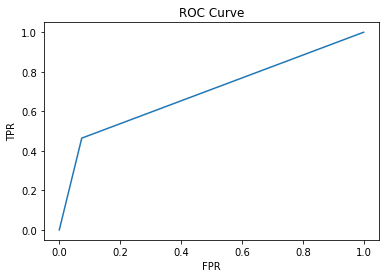

In [48]:
scores['Random Forest'] = check_model_perf(RandomForestClassifier(n_estimators=300, oob_score=True, max_features=0.8), X_train, y_train, X_test, y_test)

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
--------------------------------------------------
True Possitives  :	5
True Negatives   :	103
False Possitives :	19
False Negatives  :	23
AUC Score : 0.5114168618266979


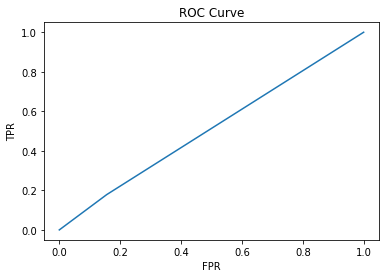

In [49]:
scores['Decision Tree'] = check_model_perf(DecisionTreeClassifier(), X_train, y_train, X_test, y_test)

<class 'sklearn.svm._classes.SVC'>
--------------------------------------------------
True Possitives  :	11
True Negatives   :	102
False Possitives :	20
False Negatives  :	17
AUC Score : 0.6144613583138173


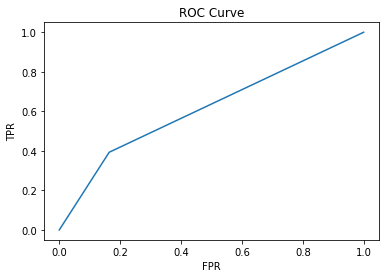

In [50]:
scores['SVC'] = check_model_perf(SVC(), X_train, y_train, X_test, y_test)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
--------------------------------------------------
True Possitives  :	21
True Negatives   :	90
False Possitives :	32
False Negatives  :	7
AUC Score : 0.7438524590163934


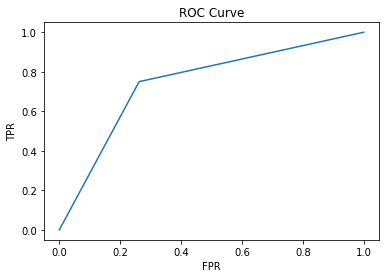

In [51]:
scores['Logistic Regression'] = check_model_perf(LogisticRegression(), X_train, y_train, X_test, y_test)

<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
--------------------------------------------------
True Possitives  :	17
True Negatives   :	90
False Possitives :	32
False Negatives  :	11
AUC Score : 0.672423887587822


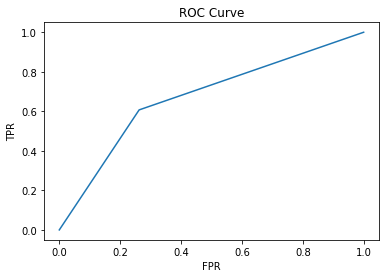

In [52]:
scores['SGD Classifier'] = check_model_perf(SGDClassifier(), X_train, y_train, X_test, y_test)

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
--------------------------------------------------
True Possitives  :	17
True Negatives   :	114
False Possitives :	8
False Negatives  :	11
AUC Score : 0.770784543325527


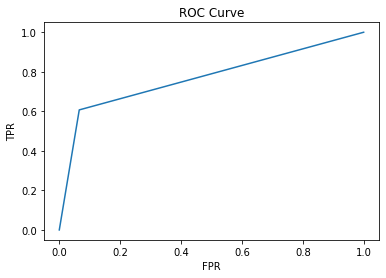

In [53]:
scores['AdaBoost'] = check_model_perf(AdaBoostClassifier(n_estimators=200), X_train, y_train, X_test, y_test)

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
--------------------------------------------------
True Possitives  :	17
True Negatives   :	105
False Possitives :	17
False Negatives  :	11
AUC Score : 0.7338992974238875


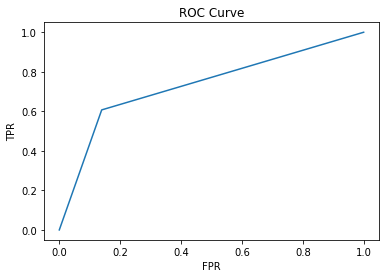

In [54]:
scores['NNet'] = check_model_perf(MLPClassifier(hidden_layer_sizes=(15,10),max_iter=600), X_train, y_train, X_test, y_test)

In [55]:
pd.DataFrame.from_dict(scores, orient='index', columns=['AUC Score']).sort_values(by=['AUC Score'], ascending=False)

,AUC Score
AdaBoost,0.770785
Logistic Regression,0.743852
NNet,0.733899
Random Forest,0.695258
SGD Classifier,0.672424
SVC,0.614461
Decision Tree,0.511417


**Clearly, linear models doesn't suit**

### Building A few Models with CV

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
y = y.ravel()

In [58]:
gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'n_estimators': [10, 20, 30, 40, 50],
            'max_features': ['log2','auto','None']
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y.ravel())
print(grid_result.best_params_)
print(grid_result.best_score_)

{'max_features': 'auto', 'n_estimators': 50}
0.7842820970127887


In [59]:
gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'criterion': ['gini','entropy'],
            'splitter': ['best','random']
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y.ravel())
print(grid_result.best_params_)
print(grid_result.best_score_)

{'criterion': 'entropy', 'splitter': 'random'}
0.6111192441760058


In [60]:
gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid={
            'criterion': ['gini','entropy'],
            'splitter': ['best','random']
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y.ravel())
print(grid_result.best_params_)
print(grid_result.best_score_)

{'criterion': 'entropy', 'splitter': 'random'}
0.6133325266544869


In [61]:
gsc = GridSearchCV(
        estimator=SVC(),
        param_grid={
            'kernel': ['rbf','poly'],
            'degree': [2,3],
            'gamma':['scale','auto']
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.802703048734764


In [62]:
gsc = GridSearchCV(
        estimator=MLPClassifier(),
        param_grid={
            'hidden_layer_sizes': [(20,10),(15,10),(15,15)],
            'max_iter': [200,500,600]
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'hidden_layer_sizes': (15, 10), 'max_iter': 200}
0.8031237502158719


/Users/parth/miniconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [63]:
gsc = GridSearchCV(
        estimator=AdaBoostClassifier(),
        param_grid={
            'n_estimators': [20,40,50,60,80,100]
        },
        cv=5, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, y)
print(grid_result.best_params_)
print(grid_result.best_score_)

{'n_estimators': 20}
0.803767829306756


### Some CV Scores for models on interest

In [64]:
from sklearn.model_selection import cross_val_score

In [65]:
model = RandomForestClassifier(n_estimators=20)
cross_val_score(model, X, y, cv=20).mean()

0.8559999999999999

In [66]:
model = MLPClassifier(hidden_layer_sizes=(20,10), max_iter=500)
cross_val_score(model, X, y, cv=20).mean()

/Users/parth/miniconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/parth/miniconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/parth/miniconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/parth/miniconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

0.8280000000000001

In [95]:
model = RandomForestClassifier(max_features=0.60, n_estimators=300, oob_score=True)
cross_val_score(model, X, y, cv=10).mean()

0.9723623418919942

In [68]:
model = AdaBoostClassifier(n_estimators=30)
cross_val_score(model, X, y, cv=10).mean()

0.866

In [69]:
model = SVC(kernel='poly', degree=3, gamma='scale')
cross_val_score(model, X, y, cv=10).mean()

0.8540000000000001

In [70]:
model = SVC(kernel='rbf')
cross_val_score(model, X, y, cv=10).mean()

0.86

### Models_for_submission

In [36]:
!mkdir models

mkdir: models: File exists


Model_name: RandomForest1.0

In [37]:
model = RandomForestClassifier(n_estimators=20)
model.fit(X,y)
pkl_filename = "models/RandomForest1.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name = MLP1.0

In [38]:
model = MLPClassifier(hidden_layer_sizes=(20,10), max_iter=500)
model.fit(X,y)
pkl_filename = "models/MLP1.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name = RandomForest2.0

In [39]:
model = RandomForestClassifier(max_features=0.30, n_estimators=200, oob_score=True)
model.fit(X,y)
pkl_filename = "models/RandomForest2.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name = SVC1.0

In [43]:
model = SVC(kernel='poly', degree=3, gamma='scale', probability=True)
model.fit(X,y)
pkl_filename = "models/SVC1.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name : RandomForest3.0 (With Feature Engineering)

In [43]:
model = RandomForestClassifier(max_features=0.70, n_estimators=300, oob_score=True)
model.fit(X,y)
pkl_filename = "models/RandomForest3.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name : RandomForest4.0

In [72]:
model = RandomForestClassifier(max_features=0.70, n_estimators=300, oob_score=True)
model.fit(X,y)
pkl_filename = "models/RandomForest4.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name : AdaBoost1.0

In [75]:
model = AdaBoostClassifier(n_estimators=30)
model.fit(X,y)
pkl_filename = "models/Adaboost1.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name : RandomForest5.0

In [77]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=11)
X_mod, y_mod = sm.fit_sample(X, y)
model = RandomForestClassifier(max_features=0.70, n_estimators=300, oob_score=True)
model.fit(X_mod,y_mod)
pkl_filename = "models/RandomForest5.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

model_name : AdaBoost2.0

In [78]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=11)
X_mod, y_mod = sm.fit_sample(X, y)
model = AdaBoostClassifier(n_estimators=30)
model.fit(X_mod,y_mod)
pkl_filename = "models/Adaboost2.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

Random Forest 6.0

In [96]:
model = RandomForestClassifier(max_features=0.60, n_estimators=300, oob_score=True)
model.fit(X,y)
pkl_filename = "models/RandomForest6.0.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)